# Pettijohn et al., 2016
Here, we are simulating the findings of Pettijon, et al. (2016) where the main finding was that a list of items broken up into multiple events were remembered better as a whole than an equivalent list studied in a single event

## Description of the original Experiment
Subjects were given a list of 40 words to remember while moving between four locations in physical space, divided into 4 ordered sub-lists of 10 words each. Subjects read one sub-list (10 words) then moved to a new location in space, either in a new room (shift condition) or a new space in the same room (no-shift condition) that was equated for physical distance, and read a second sub-list (10 words). Subjects were then given a distractor task, then asked to recall as many of the words as possible from both tested sub-lists.  Then the procedure was repeated with the second set of sub-lists. People were more accurate when there was a shift (main effect, ANOVA) but there was no effect of boundary X shift interaction (ANOVA, two words before and after a shift)


## Description of the simulations
Here, we generate a list of $n=20$ items $\mathbf{x} \in \mathbb{R}^d$ by drawing each as a random Gaussian vector $\mathbf{x}\sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ in high (d-)dimensional space, such that each item is approximately orthogonal. We will assume these are either encoded within a single event (simulating the no-switch condition) or in two events (simulating the switch condition) and evaluate the recall of all of the items for both conditions. 



# Simluations

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from models import *
from tqdm import tnrange
from simulations.exp_pettijohn import generate_task, batch

sns.set_context('paper', font_scale=1.5)

Using TensorFlow backend.


TensorFlow Version: 1.9.0
Keras      Version: 2.2.0
TensorFlow Check Passed


train either one or two event models on the list of words

In [2]:
# set the parameters, all of them!

# SEM parameters
df0 = 1.
scale0 = .2

mode = df0 * scale0 / (df0 + 2)
print("Prior variance (mode): {}".format(mode))

lmda = 10.0  # stickyness parameter
alfa = 1.  # concentration parameter

f_class = GRUEvent
f_opts=dict(var_scale0=scale0, var_df0=df0)

# create the corrupted memory trace
# noise parameters
b = 2
tau = 0.1
print("tau: {}".format(tau))

# set the parameters for the Gibbs sampler
gibbs_kwargs = dict(
    memory_alpha = alfa,
    memory_lambda = lmda,
    memory_epsilon = np.exp(-20),
    b = b,  # re-defined here for completeness
    tau = tau,  # ibid
    n_samples = 250,
    n_burnin = 100,
    leave_progress_bar=False,
)
sem_kwargs = dict(lmda=lmda, alfa=alfa, f_class=f_class, f_opts=f_opts)

epsilon_e = 0.25

Prior variance (mode): 0.0666666666667
tau: 0.1


In [3]:
# Calibrate the prior
x_list_no_switch, x_list_switch = generate_task()

mode = df0 * scale0 / (df0 + 2)
print("Prior variance (mode): {}".format(mode))
print("Median Feature variance: {}".format(np.median(np.var(x_list_no_switch[0], axis=0))))

sem_kwargs = dict(
    lmda=lmda, alfa=alfa, f_class=f_class,
    f_opts=f_opts
)
sem = SEM(**sem_kwargs)
sem.run_w_boundaries(list_events=x_list_switch)
print(sem.results.e_hat)

Prior variance (mode): 0.0666666666667
Median Feature variance: 0.0390158825488


Run SEM: 100%|██████████| 2/2 [00:05<00:00,  3.39s/it]

[0 1]


In [4]:
from tqdm import tnrange
n_batch = 25

results = []
for ii in tnrange(n_batch, desc='Batch'):
    results.append(batch(sem_kwargs, gibbs_kwargs, epsilon_e, ii))
results = pd.concat(results)

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdCYXRjaCcsIG1heD0yNSwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl93aWR0aD11J2luaXTigKY=


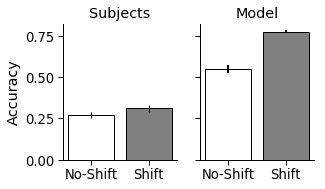

In [5]:
x = results.groupby('Condition').mean()['Overall Acc'].index
y = results.groupby('Condition').mean()['Overall Acc']
y_err = results.groupby('Condition').std()['Overall Acc'] / np.sqrt(n_batch)

fig, axes = plt.subplots(1, 2, figsize=(4.5, 2.5), sharey=True)
# plt.figure(figsize=(2, 3))
ax = axes[1]
ax.bar(x, y, lw=1, edgecolor='k', color=[[1.0, 1.0, 1.0], [0.5, 0.5, 0.5]])
ax.errorbar(x, y, y_err, marker='None', lw=2, ls='None', c='k')
# plt.ylabel('Accuracy')

sns.despine()
ax.set_title('Model')

from scipy.stats import ttest_ind
ttest_ind(
    results.loc[results.Condition == 'Shift', 'Overall Acc'],
    results.loc[results.Condition == 'No-Shift', 'Overall Acc']
)

ax = axes[0]
x = ['No-Shift', 'Shift']
y = [0.27, 0.31]
y_err = [0.02, 0.02]
# ax.figure(figsize=(3, 3))
ax.bar(x, y, color=[[1.0, 1.0, 1.0], [0.5, 0.5, 0.5]], edgecolor='k', linewidth=1)
ax.errorbar(x, y, y_err, linestyle="None", color='k')
ax.set_title('Subjects')
ax.set_ylabel('Accuracy')


ax.set_yticks(np.arange(0, 0.761, 0.25))

plt.savefig('pettijohn_gru.png', dpi=300, bbox_inches='tight')


/Users/nicholasfranklin/anaconda3/envs/sem/lib/python2.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/nicholasfranklin/anaconda3/envs/sem/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


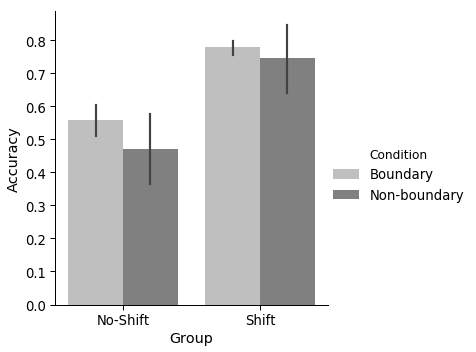

In [6]:
res = results.copy()
res.rename(columns={'Boundary Acc':'Boundary', 'Non-boundary Acc':'Non-boundary', 'Condition': 'Group'}, inplace=True)
res = res.melt(id_vars=['Group'], value_vars=['Boundary', 'Non-boundary'], value_name='Accuracy', 
               var_name='Condition')
sns.factorplot(data=res, y='Accuracy', x='Group', hue='Condition', 
               kind='bar', order=['No-Shift', 'Shift'],
               palette=[[0.75,0.75,0.75], [0.5,0.5,0.5]])

In [7]:
results.loc[results.Condition == 'Shift'].describe()

,Batch,Boundary Acc,Non-boundary Acc,Overall Acc,Reconstruction Segementation,r2
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.0
mean,12.000000,0.778667,0.746160,0.775416,0.735424,1.0
std,7.359801,0.053673,0.260257,0.049645,0.128188,0.0
min,0.000000,0.662667,0.144000,0.666000,0.566800,1.0
25%,6.000000,0.726889,0.584000,0.744600,0.627600,1.0
50%,12.000000,0.781333,0.890000,0.785600,0.697800,1.0
75%,18.000000,0.826000,0.934000,0.800800,0.839800,1.0
max,24.000000,0.850889,1.000000,0.858000,0.950000,1.0


Text(0,0.5,'Shift Accuracy')

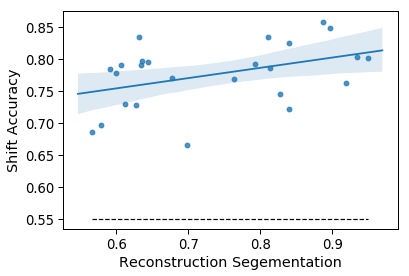

In [8]:
x = results.loc[results.Condition == 'Shift', 'Reconstruction Segementation']
y = results.loc[results.Condition == 'Shift', 'Overall Acc'].values
sns.regplot(x, y)
y_bar = np.mean(results.loc[results.Condition != 'Shift', 'Overall Acc'])
plt.plot([x.min(), x.max()], [y_bar, y_bar], 'k', ls='--')
plt.ylabel('Shift Accuracy')

Try to understand the how the parameter space effects the recovered segmentation

Text(0,0.5,'Shift Accuracy')

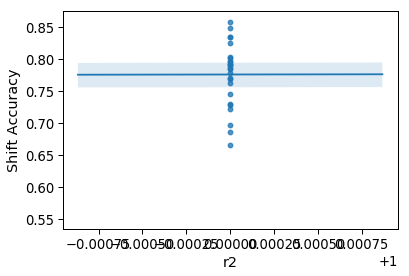

In [9]:
x = results.loc[results.Condition == 'Shift', 'r2']
y = results.loc[results.Condition == 'Shift', 'Overall Acc'].values
sns.regplot(x, y)
y_bar = np.mean(results.loc[results.Condition != 'Shift', 'Overall Acc'])
plt.plot([x.min(), x.max()], [y_bar, y_bar], 'k', ls='--')
plt.ylabel('Shift Accuracy')

In [10]:
np.mean(y[x == 1.])

0.775416

In [11]:
import os


In [12]:
os.

SyntaxError: invalid syntax (<ipython-input-12-2da6925099fa>, line 1)